# SIT742: Modern Data Science 
**(Assessment Task 02: Bank Marketing Data Analytics)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.

Prepared by **SIT742 Teaching Team**


---

**Project Group Information:**

- Names:
- Student IDs:
- Emails:

---

## 1. Import Spark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

## 2. Read and check data

In [3]:
!pip install wget  

In [0]:
import wget

link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
DataSet = wget.download(link_to_data)


In [5]:
!ls

'bank (1).csv'	 sample_data		     spark-2.4.0-bin-hadoop2.7.tgz
 bank.csv	 spark-2.4.0-bin-hadoop2.7   spark-warehouse


In [7]:
# Import the 'bank.csv' as a Spark dataframe and name it as df
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True) 

df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [8]:
# check data distribution
# you may use printSchema() 
df.printSchema() 

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## 3. Select features

In [9]:
#Select features ('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit') as df2


df2 = df.select('age','job','marital','education','default','balance','housing','loan','campaign','pdays','previous','poutcome','deposit')
cols = df2.columns
df2.printSchema()


df2.show(5)


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|       

In [10]:
# remove invalid rows/records using spark.sql 

df2.createOrReplaceTempView("Bank")

# SQL statements can be run by using the sql method
df2 = spark.sql("SELECT * FROM Bank WHERE poutcome <> 'unknown' AND poutcome <> 'other' AND job <> 'unknown' AND education <>'unknown' ")
df2.show(6)

+---+------------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|         job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+------------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|    services|married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|  technician|married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
| 34|      admin.|married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
| 53|     retired|married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
| 37|  technician|married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|
| 45|entrepreneur|married|secondary|     no|    781|     no| yes|       2|  126|       2| failure|    yes|
+---+------------+-------+---------+-

In [11]:
# convert categorical features to numeric features  using One hot encoding, 

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ['label', 'features'] + cols
df2 = df2.select(selectedCols)
df2.printSchema()
df2.show(5)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|  0.0|(23,[5,10

### 3.1 normalisation

In [12]:

#Apply Min-Max normalisation on each attribute using MinMaxScaler  
from pyspark.ml.feature import MinMaxScaler

minmaxscaler = MinMaxScaler(inputCol = "features", outputCol = "Normalised_features")
scaler = minmaxscaler.fit(df2)
df2 = scaler.transform(df2)
df2.show(15)

+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|label|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit| Normalised_features|
+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|  0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|
|  0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|
|  0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|[0.0,0.0,1.0,0.0,...|
|  0.0|(23,[4,10,13,14,1...| 53|     retired| married| tertiary|

## 4. Unsupervised learning

### 4.1 K-means

In [13]:
# Perform unsupervised learning on df2 with k-means 
# you can use whole df2 as both training and testing data, 
# evaluate the clustering result using Accuracy.  

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#here we are training a Kmeans model
k_means =KMeans(featuresCol = "Normalised_features").setK(2).setSeed(1)
NModel = k_means.fit(df2)

#here we are making predictions
Predict = NModel.transform(df2)

#here we are evaluating Clustering by Caluclating Silhouette Score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(Predict)
print("Silhouette with squared euclidean distance = " + str(silhouette))
wssse = NModel.computeCost(df2)
print("Within set of Sum Squared Errors = " + str(wssse))

#to show the results
centers = NModel.clusterCenters()
print("Cluster Centers:")
for center in centers:
  print(center)
  
accuracy_km = Predict.select("deposit","prediction").collect()

def getCluster(c):
  if c == 'yes':
    return 0
  else:
    return 1
  
def getAccuracy(outcomes):
  count = 0;
  for outcome in outcomes:
    if getCluster(outcome[0]) == outcome[1]:
      count += 1
  return count/ len(outcomes)

accuracy = getAccuracy(accuracy_km)
print("Accuracy = " + str(accuracy))

Silhouette with squared euclidean distance = 0.06039474174824377
Within set of Sum Squared Errors = 4231.872688705953
Cluster Centers:
[0.57541899 0.13184358 0.0603352  0.01340782 0.04804469 0.00782123
 0.03575419 0.03575419 0.0603352  0.01675978 0.47486034 0.45027933
 0.         0.97094972 0.99776536 0.62569832 0.92625698 0.48826816
 0.31088587 0.03688247 0.07516506 0.21330303 0.03718187]
[0.0311042  0.18351477 0.19906687 0.20139969 0.11897356 0.11508554
 0.04821151 0.04276827 0.0155521  0.02177294 0.62908243 0.26360809
 0.84836703 0.         0.99611198 0.49533437 0.88569207 0.57465008
 0.36131971 0.02968395 0.07429662 0.25288935 0.03981625]
Accuracy = 0.520861989912884


### 4.2 PCA

+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|label|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit| Normalised_features|        pca_features|
+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|  0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|[0.96364248505160...|
|  0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|[0.83734101836268...|
|  0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       

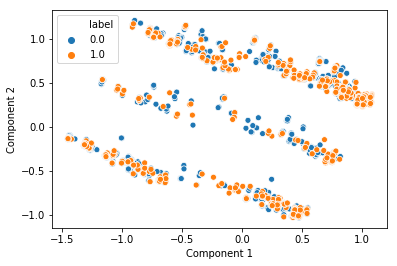

In [14]:
#Generate a scatter plot using the first two PCA components to investigate the data distribution.
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pca_mod = PCA(k=23, inputCol = "Normalised_features", outputCol = "pca_features")
pcamodel = pca_mod.fit(df2)

transformed = pcamodel.transform(df2)
transformed.show(10)

#scatter plots for 1st two components
pca_d = transformed.select('pca_features','label').toPandas()

component1 =[]
component2 = []
label =[]

for index , row in pca_d.iterrows():
  component1.append(row.pca_features[0])
  component2.append(row.pca_features[1])
  label.append(row.label)
  
pca_dframe = pd.DataFrame()
pca_dframe['Component 1'] = component1
pca_dframe['Component 2'] = component2
pca_dframe['label'] = label

pca_dframe.head(20)
sns.scatterplot(x= 'Component 1', y = 'Component 2', data = pca_dframe, hue ='label')


## 5. Supervised learning

In [15]:
train, test = df2.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1535
Test Dataset Count: 646


### 5.1 LogisticRegression

In [16]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

RegM = LogisticRegression(featuresCol ='features', labelCol ='label',maxIter = 10)
reg_model = RegM.fit(train)

Predict = reg_model.transform(test)

evaluator = MulticlassClassificationEvaluator()
accuracy = evaluator.evaluate(Predict, {evaluator.metricName: "accuracy"})
print("Accuracy = " + str(accuracy))

Accuracy = 0.7368421052631579


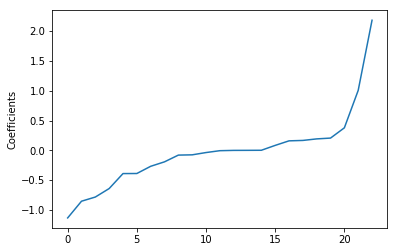

In [17]:
#Exam the coefficients
import matplotlib.pyplot as plt
import numpy as np
reg_model = np.sort(reg_model.coefficients)
plt.plot(reg_model)
plt.ylabel('Coefficients')
plt.show()

### 5.2 Decision tree

In [19]:
#Decision tree


from pyspark.ml.classification import DecisionTreeClassifier 

decision_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
decisionmodel = decision_tree.fit(train)
PredictionA = decisionmodel.transform(test)

evaluator_Acc = MulticlassClassificationEvaluator()
AccuracyA =evaluator.evaluate(PredictionA, {evaluator.metricName: "accuracy"})
print("Accuracy = " + str(AccuracyA))

Accuracy = 0.7770897832817337


### 5.3 NaiveBayes

In [20]:
#NaiveBayes


from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Naive_b = NaiveBayes(featuresCol = "Normalised_features", labelCol = "label", smoothing = 1, modelType = "multinomial")
nbmodel = Naive_b.fit(train)

PredictionB = nbmodel.transform(test)
PredictionB.select('features','label','rawPrediction','prediction','probability').show(15)

evaluator_B = MulticlassClassificationEvaluator(predictionCol = "prediction")
AccuracyB = evaluator.evaluate(PredictionB, {evaluator.metricName: "accuracy"})
print("Accuracy = " +str(AccuracyB))
 

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(23,[0,10,12,14,1...|  0.0|[-18.099423060967...|       0.0|[0.71479969025784...|
|(23,[0,10,12,14,1...|  0.0|[-19.734874367002...|       0.0|[0.71241655363917...|
|(23,[0,10,12,14,1...|  0.0|[-17.739083418637...|       0.0|[0.83907706761111...|
|(23,[0,10,12,14,1...|  0.0|[-17.613712853360...|       0.0|[0.53910788436275...|
|(23,[0,10,12,14,1...|  0.0|[-18.764334307940...|       0.0|[0.53925399923964...|
|(23,[0,10,12,14,1...|  0.0|[-18.360821086663...|       0.0|[0.53327534457948...|
|(23,[0,10,13,14,1...|  0.0|[-19.810477562475...|       0.0|[0.83405743649553...|
|(23,[0,10,13,14,1...|  0.0|[-19.027789035675...|       0.0|[0.83769169387408...|
|(23,[0,10,13,14,1...|  0.0|[-19.193148913684...|       0.0|[0.83323098523096...|
|(23,[0,10,13,14